In [ ]:
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage, transforms
import torch
import torch.nn as nn
from pathlib import Path
from math import prod


In [ ]:
!ls /notebooks/storage/stanford-cars/images/

train  valid


In [ ]:
dir_cars=Path('/notebooks/storage/stanford-cars/images')
files_cars=fv.get_image_files(dir_cars)
files_cars

(#16185) [Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002984.jpg'),Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002954.jpg'),Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002969.jpg'),Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002970.jpg'),Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002956.jpg'),Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002960.jpg'),Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002986.jpg'),Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002977.jpg'),Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002965.jpg'),Path('/notebooks/storage/stanford-cars/images/train/BMW X3 SUV 2012/002962.jpg')...]

# Parte 1 Usar red sin preentrenar
Para esto utilizare las transformaciones que me funcionaron en la tarea anterior

In [ ]:
def load_data_experimento3(f,im_size,batch_size):
    transforms=fv.aug_transforms(mult=0.5,
                                max_rotate=360,
                                max_lighting=0.75,
                                max_zoom=1.2,
#                                 max_warp=0,
                                 p_affine=0,
                                #mode='nearest',
                                )
    data = fv.DataBlock(blocks = (fv.ImageBlock, fv.CategoryBlock),
                       get_items = fv.get_image_files,
                       get_y = fv.parent_label,
                       splitter = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize(im_size),
                       batch_tfms = transforms)
    
    return data.dataloaders(f,bs=batch_size)


In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        return x.view(x.shape[0],-1)
    
def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

In [ ]:
data = load_data_experimento3(dir_cars,256,64)

# Experimento 1
Solo veo como funciona con un pequeno modelo

In [ ]:
red_neuronal1 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(64, 32), 
    nn.LeakyReLU(),
    nn.Linear(32, data.c))

num_params(red_neuronal1)

28579

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=2.7542285919189453)

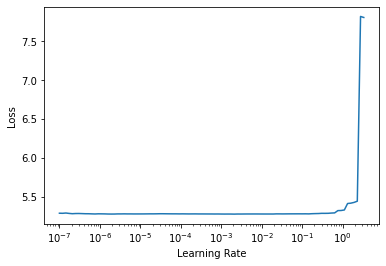

In [ ]:
learn1 = fv.Learner(data,red_neuronal1,metrics=fv.accuracy)
learn1.lr_find()

In [ ]:
learn1.fit_one_cycle(10,5e-4,mom=1)

epoch,train_loss,valid_loss,accuracy,time
0,5.278334,5.277756,0.006625,01:01
1,5.277756,5.276178,0.006250,00:55
2,5.275937,5.272809,0.008500,00:52
3,5.262439,5.257719,0.008625,00:56
4,5.230511,5.215553,0.010500,00:52
5,5.207351,5.197029,0.011375,00:52
6,5.195991,5.190584,0.012875,00:52
7,5.184531,5.184965,0.012375,00:51
8,5.183242,5.183348,0.012625,00:52
9,5.182408,5.183219,0.012750,00:52


# Experimento 1.1
Probamos normalizar los datos

In [ ]:
red_neuronal1_1 = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(64, 32), 
    nn.LeakyReLU(),
    nn.BatchNorm1d(32),
    nn.Linear(32, data.c))

num_params(red_neuronal1_1)

28169

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=9.12010818865383e-07)

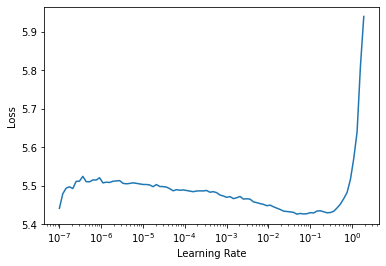

In [ ]:
learn1_1 = fv.Learner(data,red_neuronal1_1,metrics=fv.accuracy)
learn1_1.lr_find()

In [ ]:
learn1_1.fit_one_cycle(10,3e-3,mom=1)

epoch,train_loss,valid_loss,accuracy,time
0,4.876159,5.001291,0.039125,00:53
1,4.883849,5.002260,0.034875,00:53
2,4.900072,4.997550,0.039125,00:52
3,4.883384,4.994603,0.038750,00:53
4,4.883184,4.999260,0.039375,00:53
5,4.860688,4.985804,0.041375,00:52
6,4.833893,4.985502,0.039125,00:52
7,4.813617,4.980302,0.039875,00:53
8,4.828565,4.979590,0.039375,00:52
9,4.823877,4.982489,0.039375,00:52


# Experimento 2

In [ ]:
red_neuronal2 = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.LeakyReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data.c))

num_params(red_neuronal2)

1752521

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=1.3182567499825382e-06)

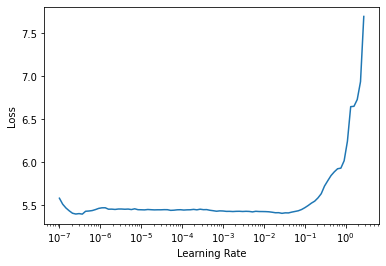

In [ ]:
# data = load_data_experimento3(dir_cars,256,32)
data = load_data_experimento3(dir_cars,256,32)
learn2 = fv.Learner(data,red_neuronal2,opt_func=fv.ranger,metrics=fv.accuracy)
learn2.lr_find()

In [ ]:
learn2.fit_one_cycle(10,3e-2,div=1.1,final_div=10000,pct_start=0.5,mom=1)

epoch,train_loss,valid_loss,accuracy,time
0,5.305676,5.181836,0.016250,02:41
1,5.215173,5.203123,0.013375,02:42
2,5.199471,5.368047,0.009500,02:42
3,5.206408,5.237028,0.016375,02:42
4,5.219208,5.282689,0.013750,02:42
5,5.190671,5.128299,0.019125,02:42
6,5.138859,5.086684,0.021750,02:42
7,5.092404,5.075934,0.025125,02:42
8,4.999778,5.018047,0.033750,02:43
9,4.959543,5.009795,0.035125,02:42


# Experimento 3
Fue mucho mas rapido que el experimento 2 y con mejor accuracy (agregue algunos MaxPool2d)

In [ ]:
red_neuronal3 = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.LeakyReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data.c))

num_params(red_neuronal3)

1752521

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=1.0964781722577754e-06)

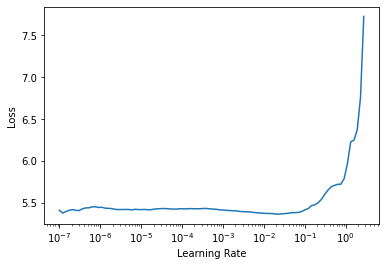

In [ ]:
# data = load_data_experimento3(dir_cars,256,32)
data = load_data_experimento3(dir_cars,256,64)
learn3 = fv.Learner(data,red_neuronal3,opt_func=fv.ranger,metrics=fv.accuracy)
learn3.lr_find()

In [ ]:
learn3.fit_one_cycle(20,2e-3,div=1.1,final_div=10000,pct_start=0.5,mom=1)
# learnf.fit_one_cycle(10,5e-4,mom=1)

epoch,train_loss,valid_loss,accuracy,time
0,3.924187,3.926835,0.149000,00:55
1,3.373783,3.397575,0.232750,00:53
2,2.763613,3.012461,0.305500,00:55
3,2.212950,2.714234,0.356125,00:53
4,1.705138,2.460325,0.412000,00:53
5,1.294871,2.318946,0.443375,00:53
6,0.960563,2.260951,0.471750,00:53
7,0.766879,2.254150,0.469875,00:53
8,0.637255,2.320692,0.475750,00:54
9,0.520664,2.347308,0.476250,00:53


# Experimento 4

In [ ]:
red_neuronal4 = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.Sigmoid(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.Sigmoid(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data.c))

num_params(red_neuronal4)

1752521

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=7.585775847473997e-07)

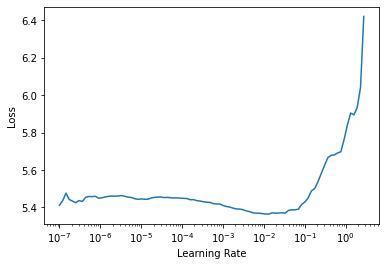

In [ ]:
# data = load_data_experimento3(dir_cars,256,32)
# data = load_data_experimento3(dir_cars,256,64)
learn4 = fv.Learner(data,red_neuronal4,opt_func=fv.ranger,metrics=fv.accuracy)
learn4.lr_find()

In [ ]:
learn4.fit_one_cycle(20,1e-3,div=1.1,final_div=10000,pct_start=0.5,mom=1)

epoch,train_loss,valid_loss,accuracy,time
0,3.725993,3.988912,0.123250,00:53
1,3.686776,3.962444,0.127625,00:53
2,3.643190,3.932337,0.132875,00:53
3,3.571138,3.906973,0.139000,00:53
4,3.567329,3.887411,0.138875,00:54
5,3.522985,3.855804,0.145875,00:53
6,3.472795,3.830279,0.147125,00:52
7,3.424305,3.813775,0.153875,00:52
8,3.379329,3.780545,0.158375,00:53
9,3.366017,3.765936,0.164000,00:53


In [ ]:
"""
import fastai.data.all as fd
import torchvision.transforms.functional as F
import random
# a = F.to_pil_image(a)
def aug(x):
#     transforms.ToPILImage()(x)
    rnd_gray = transforms.RandomGrayscale(p=0.1)
    img = rnd_gray(x)
    print('hola')
    return img

class Custom_transforms(fd.Transform):
#     def __init__(self,aug):
#         print('holainit')
#         self.aug=aug

#     def encodes(self,x:ToTensor):
    def encodes(self,x:fv.TensorImage):
#         aug_img=aug(x)
        print('hpolaencod')
        transforms.ToPILImage()(x)
#         return aug_img
#         rnd_gray = transforms.RandomGrayscale(p=0.8)
#         img = rnd_gray(x)
#         print('hola')
#         return img
#         return fv.TensorImage(aug(F.to_pil_image(x)))
#         return F.to_grayscale(x)
        input_mode = x.mode
        img = x.convert('L')

        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img] * 3)

        img = Image.fromarray(np_img, 'RGB').convert(input_mode)
        return img
    """

#Intentos fallidos del punto 5 :'c No lo logre

# Parte 2 pre-entrenando la red
Usare mi modelo del experimento 3 que fue el que mayor accuracy me dio y preentrenare con el dataset de birds

In [ ]:
red_neuronal_pre = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.LeakyReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 200))

num_params(red_neuronal_pre)

1753806

In [ ]:
!ls /notebooks/storage/birds/

birds(small).zip  train  valid


In [ ]:
dir_pretrain=Path('/notebooks/storage/birds')
files_pretrain=fv.get_image_files(dir_pretrain)
files_pretrain

(#11788) [Path('/notebooks/storage/birds/train/Mallard/Mallard_0005_76026.jpg'),Path('/notebooks/storage/birds/train/Mallard/Mallard_0093_77419.jpg'),Path('/notebooks/storage/birds/train/Mallard/Mallard_0098_77490.jpg'),Path('/notebooks/storage/birds/train/Mallard/Mallard_0136_76593.jpg'),Path('/notebooks/storage/birds/train/Mallard/Mallard_0018_76511.jpg'),Path('/notebooks/storage/birds/train/Mallard/Mallard_0061_76378.jpg'),Path('/notebooks/storage/birds/train/Mallard/Mallard_0086_76567.jpg'),Path('/notebooks/storage/birds/train/Mallard/Mallard_0069_76926.jpg'),Path('/notebooks/storage/birds/train/Mallard/Mallard_0103_77105.jpg'),Path('/notebooks/storage/birds/train/Mallard/Mallard_0052_76946.jpg')...]

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.0010000000474974513)

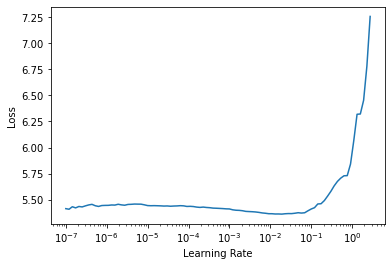

In [ ]:
data = load_data_experimento3(dir_pretrain,256,64)
learn_pre = fv.Learner(data,red_neuronal_pre,opt_func=fv.ranger,metrics=fv.accuracy)
learn_pre.lr_find()

In [ ]:
learn_pre.fit_one_cycle(20,3e-3,div=1.1,final_div=10000,pct_start=0.5,mom=1)
# learnf.fit_one_cycle(10,5e-4,mom=1)

epoch,train_loss,valid_loss,accuracy,time
0,5.138300,4.972903,0.026579,00:18
1,4.887108,4.730914,0.040387,00:17
2,4.689399,4.588561,0.049361,00:17
3,4.497323,4.351841,0.069382,00:17
4,4.312833,4.300851,0.070763,00:17
5,4.157932,4.099276,0.096652,00:17
6,4.004990,4.388465,0.074732,00:17
7,3.860888,3.784007,0.142216,00:17
8,3.672060,3.848284,0.133414,00:17
9,3.475709,3.510765,0.183983,00:17


In [ ]:
dir_cars=Path('/notebooks/storage/stanford-cars/images')
files_cars=fv.get_image_files(dir_cars)
data_real= load_data_experimento3(dir_cars,256,64)
red_neuronal_pre[-1] = nn.Linear(256,data_real.c)
data_real.c

195

# Experimento 5 preentrenando congelando hasta la capa -4

In [ ]:
def mi_splitter(m):
    return [list(fv.params(x)) for x in [m[:-4],m[-4]]] #La parte lineal

In [ ]:
learner5 = fv.Learner(data_real,red_neuronal_pre,opt_func=fv.ranger,metrics=fv.accuracy,splitter=mi_splitter)

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=2.511886486900039e-05)

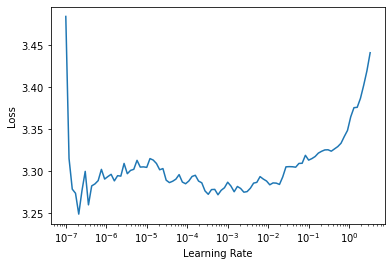

In [ ]:
learner5.freeze()
learner5.lr_find()
# learn_pre.fit_one_cycle(20,3e-3,div=1.1,final_div=10000,pct_start=0.5,mom=1)
# learnf.fit_one_cycle(10,5e-4,mom=1)

In [ ]:
learner5.fit_one_cycle(10,5e-5,div=1.1,final_div=10000,pct_start=0.5,mom=1)

epoch,train_loss,valid_loss,accuracy,time
0,3.330742,4.053364,0.225875,00:53
1,3.334422,4.048319,0.228625,00:53
2,3.314388,4.054751,0.228250,00:54
3,3.324984,4.046682,0.228000,00:54
4,3.319678,4.056052,0.225250,00:53
5,3.334349,4.045571,0.224375,00:52
6,3.325301,4.045120,0.226000,00:53
7,3.325074,4.046297,0.226875,00:53
8,3.311150,4.042910,0.226250,00:52
9,3.321518,4.042017,0.225250,00:54


# Experimento 6 preentrenando congelando hasta la capa -6

In [ ]:
def mi_splitter(m):
    return [list(fv.params(x)) for x in [m[:-6],m[-6]]]

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=2.0892961401841603e-05)

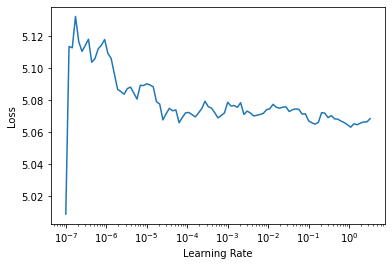

In [ ]:
learner6 = fv.Learner(data_real,red_neuronal_pre,opt_func=fv.ranger,metrics=fv.accuracy,splitter=mi_splitter)
learner6.freeze()
learner6.lr_find()

In [ ]:
learner6.fit_one_cycle(10,1e-1,div=1.1,final_div=10000,pct_start=0.5,mom=1)

epoch,train_loss,valid_loss,accuracy,time
0,5.067813,5.139962,0.027250,01:04
1,5.076284,5.137308,0.028625,01:01
2,5.074736,5.242653,0.024500,01:01
3,5.066833,5.503053,0.027250,01:10
4,5.063224,5.117958,0.026250,01:01
5,5.069051,5.169841,0.026000,01:02
6,5.056863,5.099620,0.030625,01:10
7,5.029686,5.128269,0.032750,01:12
8,5.027428,5.099028,0.031750,01:03
9,5.021719,5.106320,0.033250,01:02
